In [2]:
from google.colab import files
uploaded = files.upload()


Saving Archive.zip to Archive.zip


In [3]:
import zipfile
import os

zip_path = "Archive.zip"
extract_dir = "dataset_casco"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Mostrar estructura básica para verificar
print("Contenido descomprimido en:", os.listdir(extract_dir))


Contenido descomprimido en: ['sin_casco', '__MACOSX', 'casco']


In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Transformaciones básicas: tamaño fijo + normalización
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # para imágenes RGB
])

# Cargar dataset desde carpeta
data_dir = "dataset_casco"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dividir 80% train y 20% val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Verificar clases
print("Clases:", dataset.classes)
print(f"Total imágenes: {len(dataset)} (train: {train_size}, val: {val_size})")


Clases: ['__MACOSX', 'casco', 'sin_casco']
Total imágenes: 204 (train: 163, val: 41)


In [5]:
import shutil

# Eliminar carpeta "__MACOSX" si existe
macosx_path = os.path.join(data_dir, "__MACOSX")
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)
    print("Carpeta '__MACOSX' eliminada.")

# Recargar dataset sin la carpeta basura
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Reparto train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Verificación
print("Clases:", dataset.classes)
print(f"Total imágenes: {len(dataset)} (train: {train_size}, val: {val_size})")


Carpeta '__MACOSX' eliminada.
Clases: ['casco', 'sin_casco']
Total imágenes: 102 (train: 81, val: 21)


In [6]:
import torch.nn as nn
from torchvision import models

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo preentrenado
model = models.resnet18(pretrained=True)

# Congelar capas base (opcional para fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la capa final
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 clases: casco y sin_casco

model = model.to(device)
print("Modelo listo en:", device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.1MB/s]


Modelo listo en: cpu


In [7]:
import torch.optim as optim

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador (solo entrenamos la capa final)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Número de épocas
num_epochs = 10


In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validación
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Época {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")


Época 1/10 | Train Loss: 0.7325 | Acc: 0.4691 | Val Loss: 0.5068 | Acc: 0.6667
Época 2/10 | Train Loss: 0.5758 | Acc: 0.5802 | Val Loss: 0.4297 | Acc: 0.6667
Época 3/10 | Train Loss: 0.4952 | Acc: 0.6667 | Val Loss: 0.3557 | Acc: 0.9048
Época 4/10 | Train Loss: 0.3802 | Acc: 0.9136 | Val Loss: 0.3139 | Acc: 0.9048
Época 5/10 | Train Loss: 0.3361 | Acc: 0.9630 | Val Loss: 0.2883 | Acc: 0.9524
Época 6/10 | Train Loss: 0.2767 | Acc: 0.9630 | Val Loss: 0.2210 | Acc: 0.9524
Época 7/10 | Train Loss: 0.2204 | Acc: 0.9753 | Val Loss: 0.1829 | Acc: 1.0000
Época 8/10 | Train Loss: 0.1923 | Acc: 0.9877 | Val Loss: 0.1620 | Acc: 1.0000
Época 9/10 | Train Loss: 0.1757 | Acc: 0.9877 | Val Loss: 0.1467 | Acc: 1.0000
Época 10/10 | Train Loss: 0.1651 | Acc: 0.9630 | Val Loss: 0.1378 | Acc: 1.0000


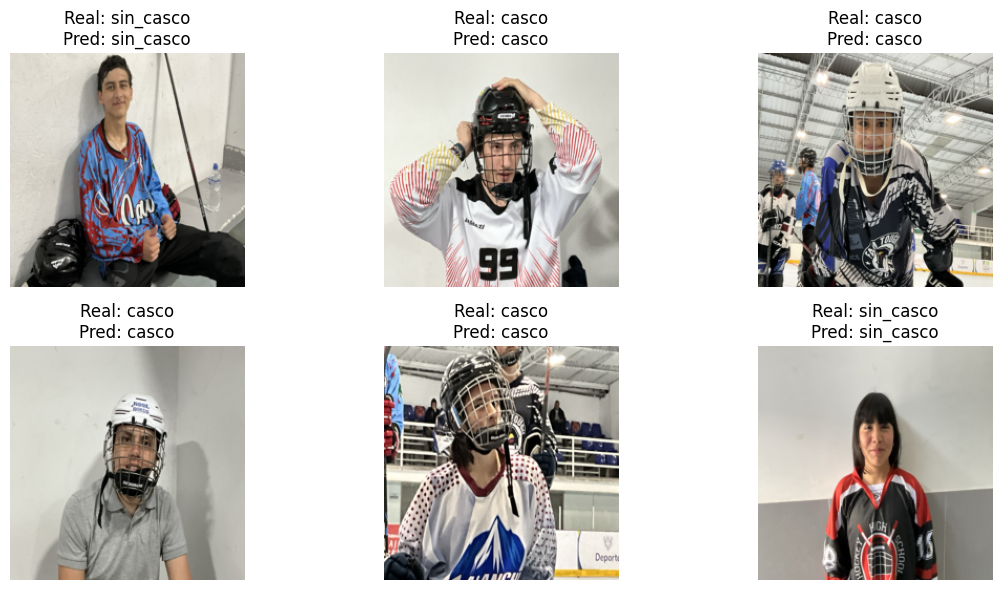

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Función auxiliar para desnormalizar imagen
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # CxHxW → HxWxC
    img = img * 0.5 + 0.5  # desnormalizar
    return np.clip(img, 0, 1)

# Obtener algunas muestras del val_loader
model.eval()
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Obtener predicciones
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Mostrar primeras 6 imágenes con predicción
fig = plt.figure(figsize=(12, 6))
for idx in range(6):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.imshow(imshow(images[idx].cpu()))
    ax.set_title(f"Real: {dataset.classes[labels[idx]]}\nPred: {dataset.classes[preds[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
torch.save(model.state_dict(), "modelo_casco.pth")
print("Modelo guardado como modelo_casco.pth")


Modelo guardado como modelo_casco.pth


In [12]:
from google.colab import files
files.download("modelo_casco.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>